# Prerequisites

- Python 3.10.4

> Warning: Installation from conda environment may take few minutes

Configuring conda environment
```cmd
conda create -n ca2_env
conda activate ca2_env
conda install -c conda-forge pingouin
```

Installing jupyter notebook on ca2_env environment
```cmd
conda install jupyter notebook
python -m ipykernel install --name ca2_env
```

Run jupiter 
```cmd
jupyter notebook
```

In [1]:
from preamble import agriculture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns;
from scipy import stats

# Change default colormap
plt.rcParams["image.cmap"] = "Set2"
sns.set_palette("Set2")
sns.color_palette("Set2")


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [2]:
# Datasets
agriculture_df = pd.read_csv("../data/agriculture_dataset.csv")
ireland = agriculture_df.query("country == 'IE'")
eu_country_codes = pd.read_csv("../data/eu_country_codes.csv");
eu_country_codes.columns = ["id","description","iso2"]
eu_country_codes = eu_country_codes[["iso2","description"]].set_index("iso2")
country_codes_dic =  eu_country_codes.description.to_dict()
columns_dic = agriculture.columns_dic

# Variable Analysis

In [3]:
ireland.shape

(17, 24)

In [4]:
ireland.describe()

,year,crop_mean_residues_kg,crop_production_idx,cereals_produce_price_usd_tonne,employment_ratio_rural_areas_pct,female_employment_ratio_rural_areas_pct,male_employment_ratio_rural_areas_pct,mean_weekly_working_hours,female_mean_weekly_working_hours,male_mean_weekly_working_hours,...,avg_export_idx,total_subsides_on_field_crops,rented_land_ha,rent_paid,total_uaa_ha,pct_rented_land_of_uaa,gross_value_added,compensation_of_employees,wages_and_salaries,prod_cereals_real_price
count,17.000000,1.700000e+01,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,2012.000000,4.758808e+06,115.236633,183.519608,56.412941,48.940588,63.793824,50.147647,34.867059,52.392353,...,137.152941,1151.529412,25.093897,9851.291176,70.119971,35.350475,2252.505882,638.635294,524.435294,105.094706
std,5.049752,7.176535e+05,34.784519,47.713041,3.344534,2.261085,5.025201,1.626547,1.992880,1.357864,...,76.240459,3981.291328,7.733230,4253.233728,11.661572,5.448977,711.955944,76.506404,63.283182,28.633327
min,2004.000000,3.896111e+06,69.024767,126.666667,50.600000,45.210000,55.970000,48.060000,31.200000,50.570000,...,40.200000,0.000000,15.290000,5367.000000,52.730000,28.996776,946.500000,529.900000,432.500000,70.380000
25%,2008.000000,4.134453e+06,97.608000,148.500000,53.840000,47.210000,59.940000,49.330000,33.860000,51.680000,...,94.800000,28.000000,20.080000,6990.000000,60.950000,30.488009,1733.700000,595.400000,486.600000,89.780000
50%,2012.000000,4.711826e+06,104.182000,163.000000,56.760000,49.330000,63.280000,49.630000,34.880000,52.000000,...,114.800000,76.000000,22.060000,7603.000000,67.870000,34.778496,2070.000000,613.700000,510.400000,100.130000
75%,2016.000000,5.054516e+06,113.582000,208.333333,57.670000,50.110000,68.290000,50.470000,35.130000,52.880000,...,140.000000,383.000000,32.360000,14683.000000,81.200000,39.852217,2558.400000,685.700000,565.300000,112.030000
max,2020.000000,6.566029e+06,191.840000,276.333333,63.270000,53.120000,73.320000,54.090000,38.470000,55.740000,...,304.800000,16581.000000,39.180000,18255.000000,88.580000,44.231203,3501.900000,789.500000,649.500000,166.610000


<AxesSubplot:>

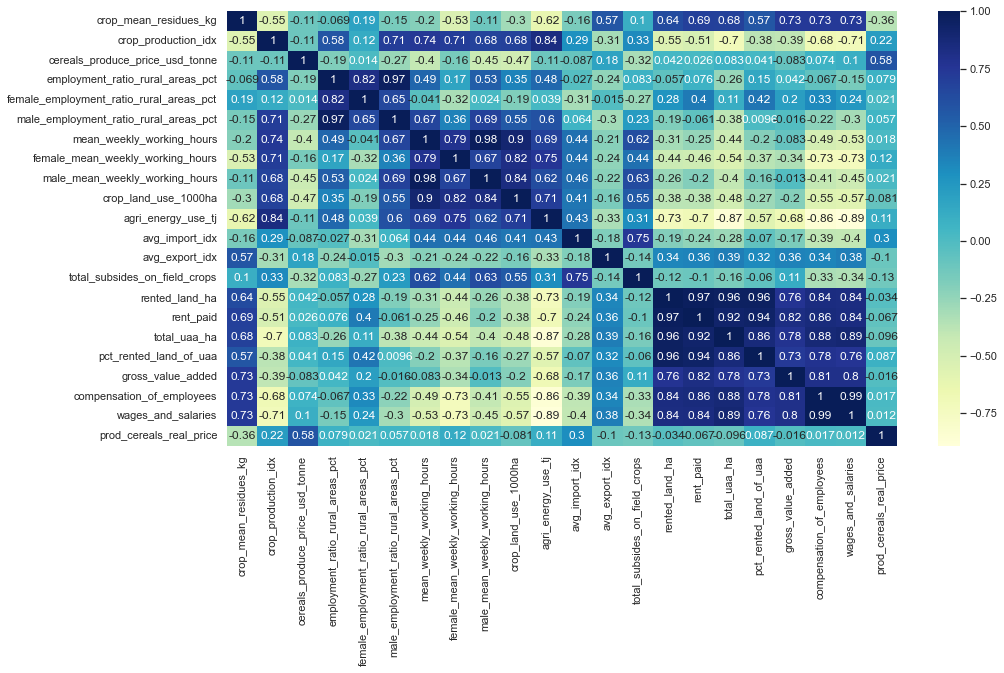

In [5]:
continuous_variables = ireland.dtypes[ireland.dtypes == np.float64].index
data = ireland[continuous_variables]
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, )

In [6]:
# Gross Value Added
ireland.gross_value_added.describe()

count      17.000000
mean     2252.505882
std       711.955944
min       946.500000
25%      1733.700000
50%      2070.000000
75%      2558.400000
max      3501.900000
Name: gross_value_added, dtype: float64

In [7]:
ireland.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 221 to 237
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  17 non-null     object 
 1   year                                     17 non-null     int64  
 2   crop_mean_residues_kg                    17 non-null     float64
 3   crop_production_idx                      17 non-null     float64
 4   cereals_produce_price_usd_tonne          17 non-null     float64
 5   employment_ratio_rural_areas_pct         17 non-null     float64
 6   female_employment_ratio_rural_areas_pct  17 non-null     float64
 7   male_employment_ratio_rural_areas_pct    17 non-null     float64
 8   mean_weekly_working_hours                17 non-null     float64
 9   female_mean_weekly_working_hours         17 non-null     float64
 10  male_mean_weekly_working_hours           17 non-n

# Analysis of countries with similar characteristics to Ireland

Get countries that have similar GVA or Total Used Agricultural Area similar. 
- Criteria 1: Countries with GVA on 75% min and max range of Ireland mean GVA
- Criteria 2: Test Anova and post hoc analisys to identify countries

## Criteria 1: +/- 75 of Irelands GVA

In [8]:
# Countries with simliar utilised agricultural area than IE
uaa_means = agriculture_df.groupby('country').total_uaa_ha.mean().reset_index()
gva_means = agriculture_df.groupby('country').gross_value_added.mean().reset_index()
ie_uua = uaa_means.query("country == 'IE'").total_uaa_ha.values[0]
ie_GVA = gva_means.query("country == 'IE'").gross_value_added.values[0]

country_with_similar_uaa = uaa_means.query(f"\
        total_uaa_ha >= {ie_uua * 0.25} and \
        total_uaa_ha <= {ie_uua * 1.75}").country.values.flatten()

counties_with_similar_gva = gva_means.query(f"\
        gross_value_added >= {ie_GVA * 0.25} and \
        gross_value_added <= {ie_GVA * 1.75} \
").country.values.flatten()

# Set similar countries to Ireland by UAA and GVA
similar_countries = list(set(country_with_similar_uaa).intersection(set(counties_with_similar_gva)))

## Criteria 2: Anova

### T-Test Assumptions

1. The first assumption made regarding t-tests concerns the scale of measurement. The assumption for a t-test is that the scale of measurement applied to the data collected follows a continuous or ordinal scale, such as the scores for an IQ test.

2. The second assumption made is that of a simple random sample, that the data is collected from a representative, randomly selected portion of the total population.

3. The third assumption is the data, when plotted, results in a normal distribution, bell-shaped distribution curve. When a normal distribution is assumed, one can specify a level of probability (alpha level, level of significance, p) as a criterion for acceptance. In most cases, a 5% value can be assumed.

4. The fourth assumption is a reasonably large sample size is used. A larger sample size means the distribution of results should approach a normal bell-shaped curve.


5. The final assumption is homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal.

ref: Bartlett, M. S. (1937). Properties of sufficiency and statistical tests. Proc. R. Soc. Lond. A, 160(901), 268-282.

In [9]:
results = agriculture.anova_paircomparison_ireland_oms(agriculture_df,continuous_variables)

                           crop_mean_residues_kg                                 
Candidates for ANOVA ['AT', 'BE', 'EE', 'FI', 'GR', 'IT', 'SK', 'IE']
             df        sum_sq       mean_sq           F         PR(>F)
country     7.0  4.106704e+15  5.866721e+14  775.649394  1.538602e-101
Residual  128.0  9.681439e+13  7.563624e+11         NaN            NaN
                           crop_production_idx                                 
Candidates for ANOVA ['CZ', 'DE', 'DK', 'EE', 'LV', 'NL', 'PT', 'RO', 'IE']
             df        sum_sq      mean_sq         F    PR(>F)
country     8.0  21875.173095  2734.396637  5.081303  0.000014
Residual  144.0  77490.578945   538.129020       NaN       NaN
                           cereals_produce_price_usd_tonne                                 
Candidates for ANOVA ['AT', 'BE', 'BG', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HU', 'IT', 'LT', 'LV', 'NL', 'PL', 'PT', 'RO', 'SI', 'SK', 'IE']
             df         sum_sq       mean_sq

In [10]:
print("Anava result comparison for Ireland with other Members States and variables")
results_pd = pd.DataFrame.from_records(np.array(results)[1:,:], columns=results[0]);
results_pd["country_name"] = results_pd.country.apply(lambda x: country_codes_dic.get(x));
results_pd

Anava result comparison for Ireland with other Members States and variables


,country,variable,anova_score,country_name
0,BG,total_subsides_on_field_crops,0.7246195898894956,(BG) Bulgaria
1,SK,prod_cereals_real_price,0.9998980911821606,(SK) Slovakia


> The following 2 countries are the same as Ireland 

- Bulgaria subsides on field crops
- Slovakia Production of cereals Price

However for the shake of analysis indpendant variables, it will be used Criteria 1 for the machine learning. In this exercise we have confirm which countries has similar statiscal characteristics with Ireland. It will be possible to break down europe countries by sub reginal areas which they most likely be closer to the size of Ireland on the selected variables of study.

In [11]:
# Set similar countries to Ireland by UAA and GVA as per Criteria 1 combined with Criteria 2
similar_countries = list(set(country_with_similar_uaa).intersection(set(counties_with_similar_gva)))
similar_countries = similar_countries + list(results_pd.country.unique())
similar_countries

['BE', 'PT', 'LV', 'IE', 'DK', 'LT', 'BG', 'SK']

# Inferential Statistics Analysis of variables of the selected countries

In [12]:
dataset = agriculture_df.query("country in @similar_countries")

The criteria for selecting the above countries for the comparison analysis will be further investigating by comparing characteristics of them and analysis on the mean, variance and of the samples taken.

In [13]:
n = len(dataset.year.unique())
print(f"Sample data {n}")

Sample data 17


## 1. Ireland 

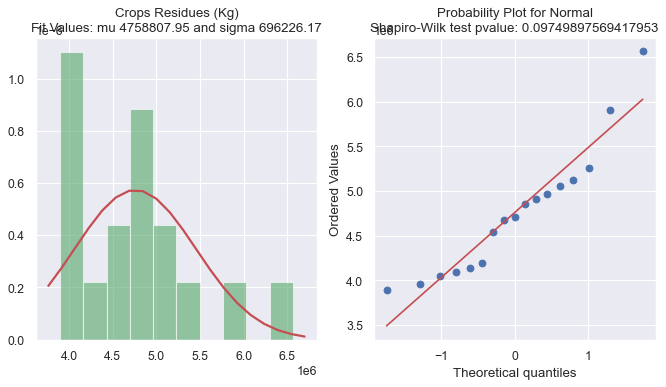

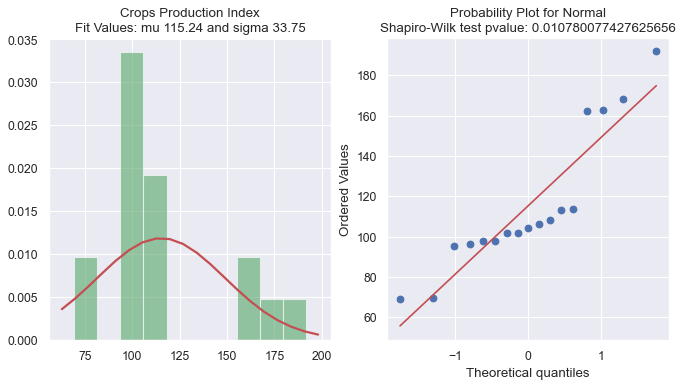

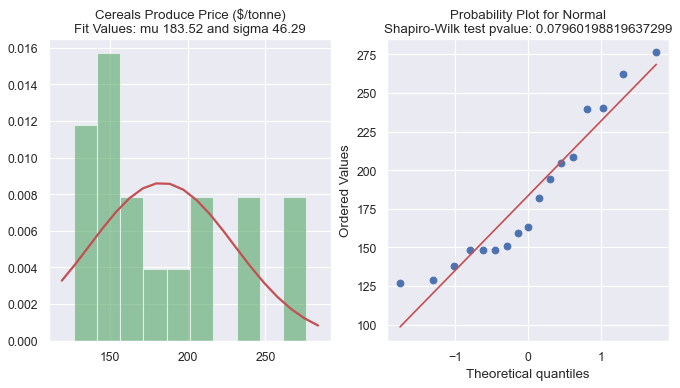

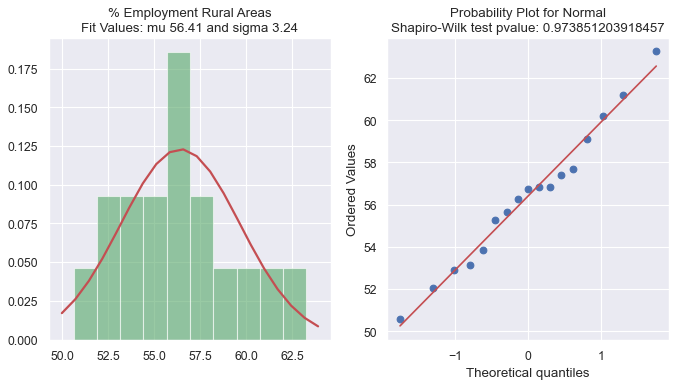

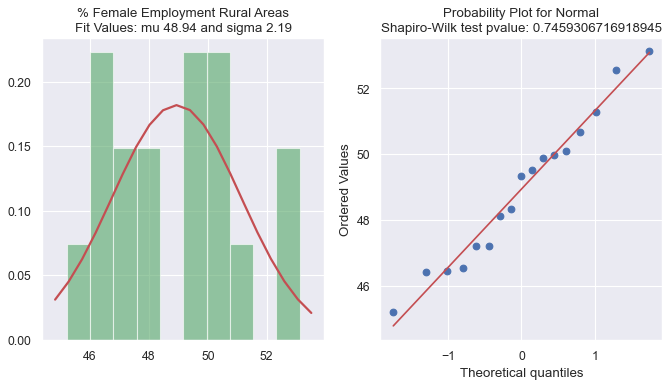

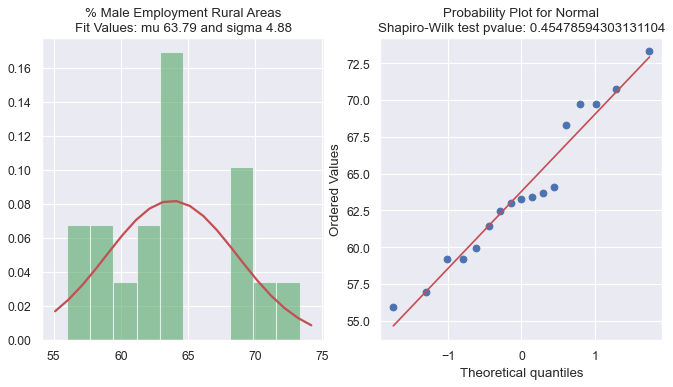

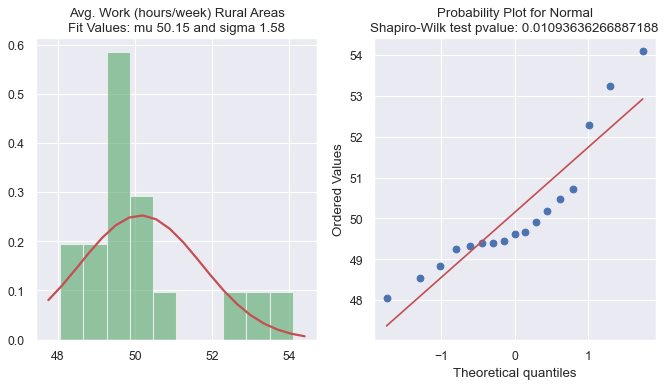

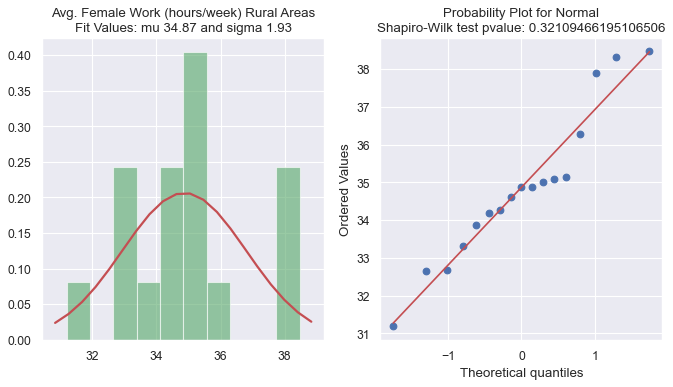

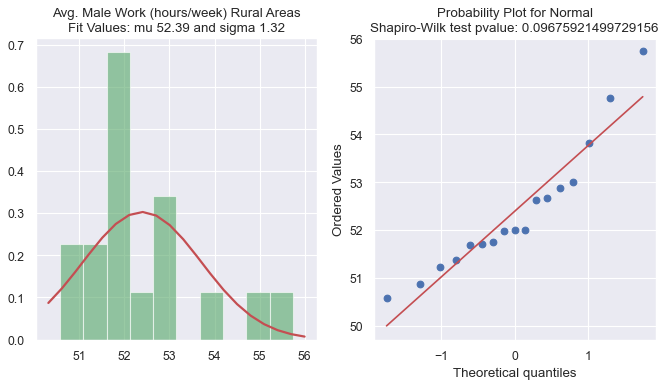

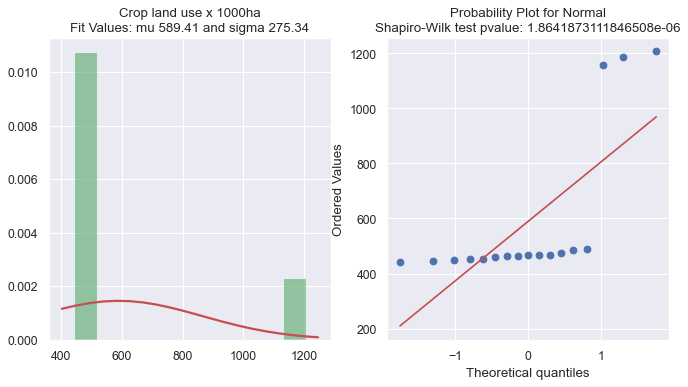

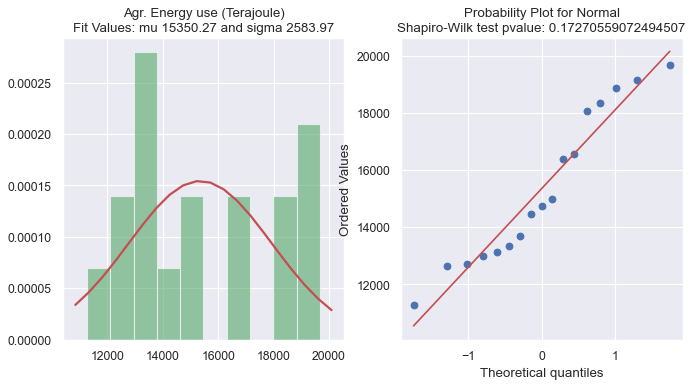

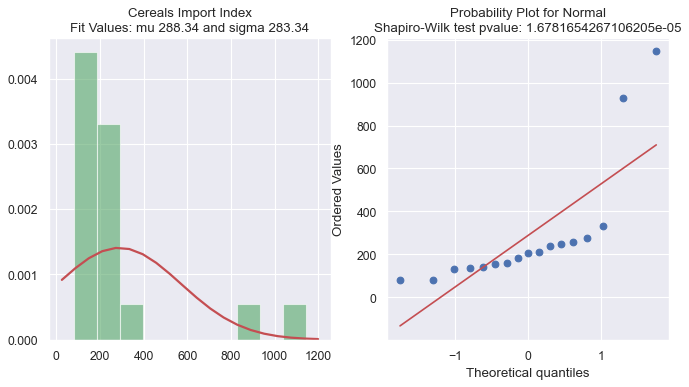

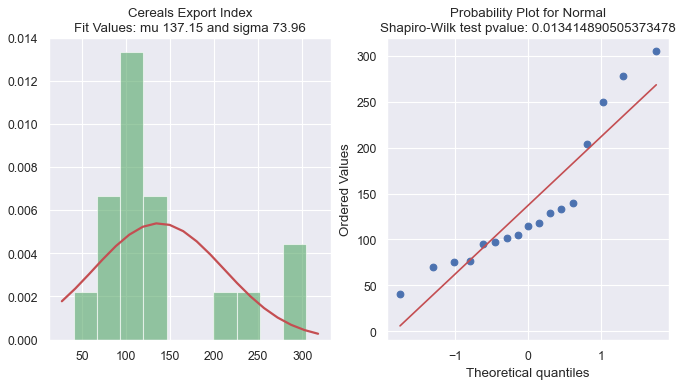

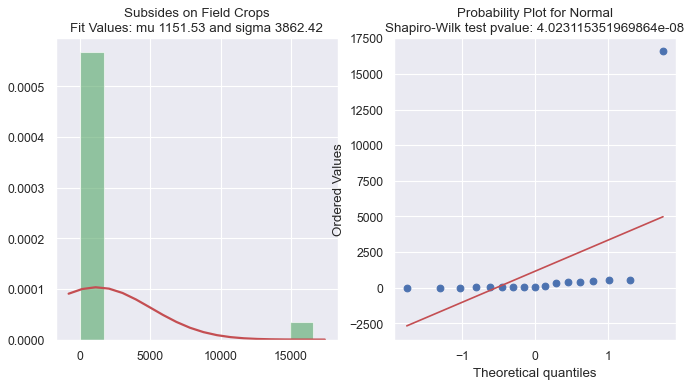

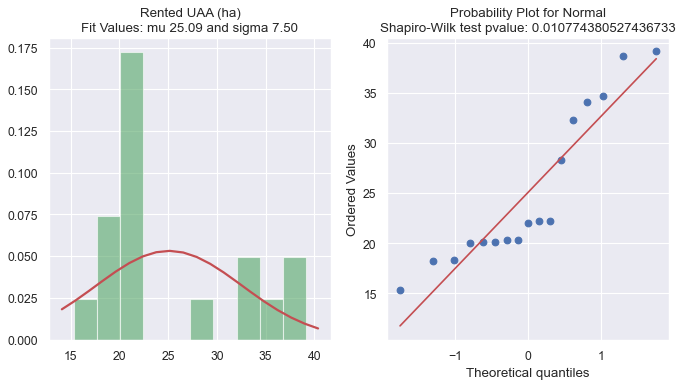

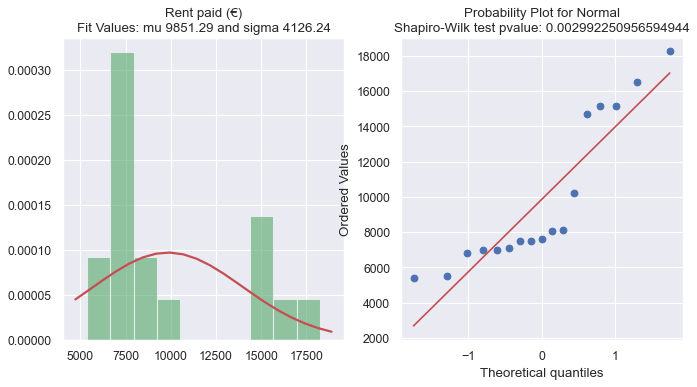

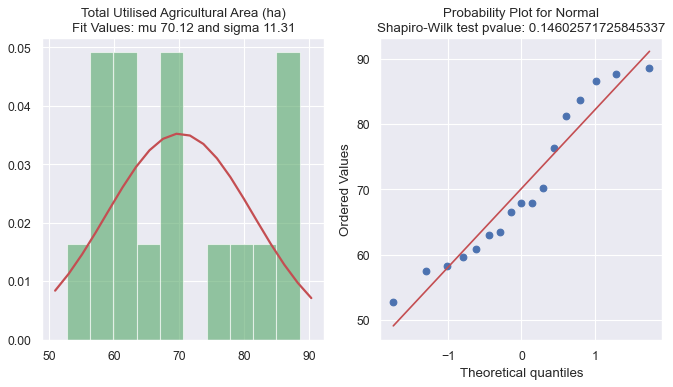

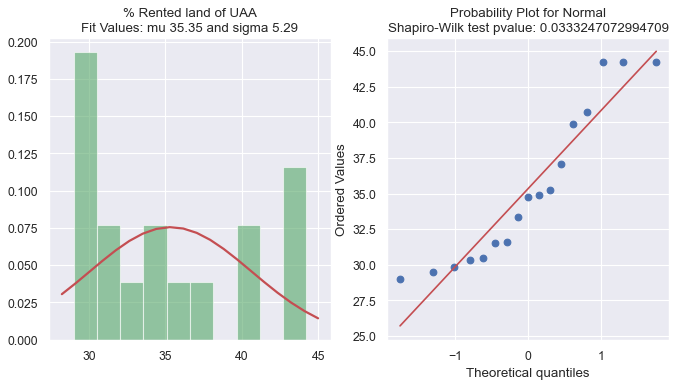

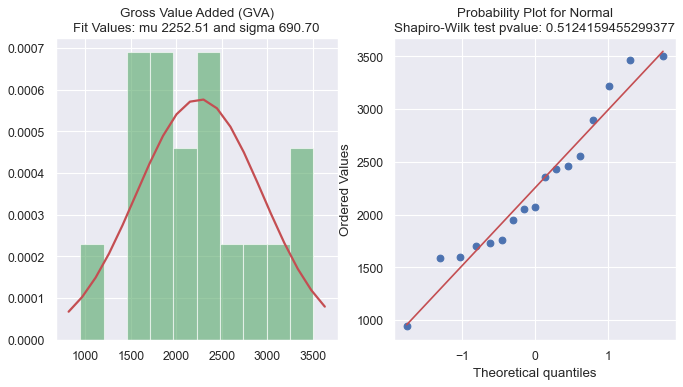

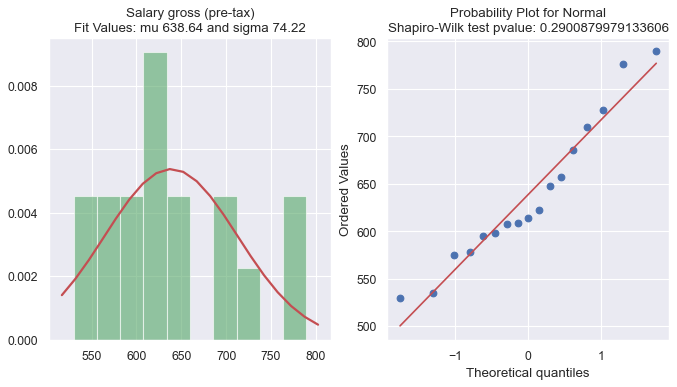

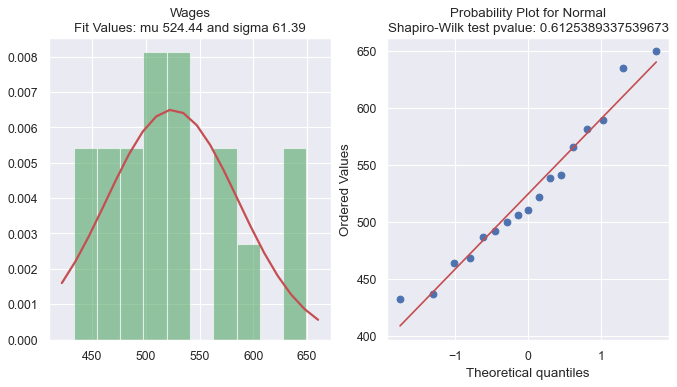

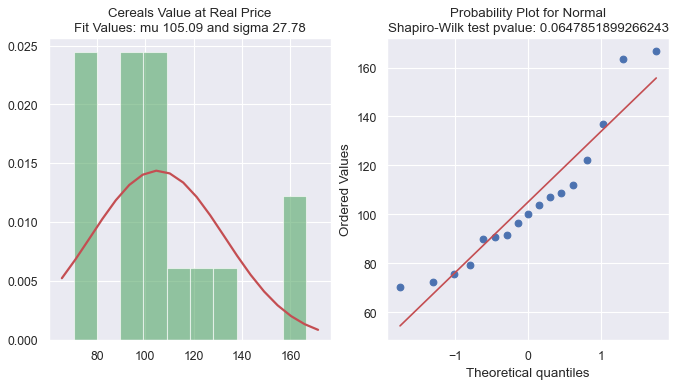

In [14]:
# Normal distribution check
results = [["variable","pvalue"]]
for variable in continuous_variables:
    pvalue = agriculture.plot_normal_dist(ireland[variable],
                     columns_dic.get(variable), 
                     f"../visualizations/01_stats_normaldist_{variable}.png")
    if(pvalue > 0.05):
        results.append([variable,pvalue])

In [16]:
ireland_var_normdist = pd.DataFrame.from_records(np.array(results)[1:,:], columns=results[0])
ireland_var_normdist.sort_values("variable")

,variable,pvalue
7,agri_energy_use_tj,0.17270559072494507
1,cereals_produce_price_usd_tonne,0.07960198819637299
10,compensation_of_employees,0.2900879979133606
0,crop_mean_residues_kg,0.09749897569417953
2,employment_ratio_rural_areas_pct,0.973851203918457
3,female_employment_ratio_rural_areas_pct,0.7459306716918945
5,female_mean_weekly_working_hours,0.32109466195106506
9,gross_value_added,0.5124159455299377
4,male_employment_ratio_rural_areas_pct,0.45478594303131104
6,male_mean_weekly_working_hours,0.09675921499729156


The following variables shows approximately Normal distribution as per fit to histogram plot and regarding probability Plot: The below variables data points plots looks fairly straight, indicating normality.

    - "agri_energy_use_tj"
    - "cereals_produce_price_usd_tonne"
    - "compensation_of_employees"
    - "crop_mean_residues_kg"
    - "employment_ratio_rural_areas_pct"
    - "female_employment_ratio_rural_areas_pct"
    - "female_mean_weekly_working_hours"
    - "gross_value_added"
    - "male_employment_ratio_rural_areas_pct"
    - "male_mean_weekly_working_hours"
    - "prod_cereals_real_price"
    - "total_uaa_ha"
    - "wages_and_salaries"


In [17]:
variables_normally_dist_candidates = ireland_var_normdist.variable.unique()

In [18]:
# Shapiro wilk test for normality in Irish dataset
variables_normally_dist = []
for variable in variables_normally_dist_candidates:
    stat, pvalue = stats.shapiro(ireland[variable])
    result = ""
    if(pvalue > 0.05):
        variables_normally_dist.append(variable)
    else:
        print(f"Removing {variable} with pvalue: {pvalue}")
    


In [19]:
variables_normally_dist

['crop_mean_residues_kg',
 'cereals_produce_price_usd_tonne',
 'employment_ratio_rural_areas_pct',
 'female_employment_ratio_rural_areas_pct',
 'male_employment_ratio_rural_areas_pct',
 'female_mean_weekly_working_hours',
 'male_mean_weekly_working_hours',
 'agri_energy_use_tj',
 'total_uaa_ha',
 'gross_value_added',
 'compensation_of_employees',
 'wages_and_salaries',
 'prod_cereals_real_price']

# 2. Other member states and Ireland

## Check homogeneity of variances all countries / variable

In [20]:
#Homogeinity of variance: Levene's test
arr = [[]]
count = 0 
for variable in variables_normally_dist:
    levenes_result = pg.homoscedasticity(dataset, dv=variable, group='country',method='levene')
    if(count == 0):
        arr[0] = list(np.append(levenes_result.values.flatten(),[variable, "all"]))
    else:
        arr.insert(count,list(np.append(levenes_result.values.flatten(),[variable, "all"])))
    
    count+=1

levene_df = pd.DataFrame(arr,columns=["W","pvalue","equal_var","variable","country"])       
levene_df.query("equal_var == True")


,W,pvalue,equal_var,variable,country
1,0.198627,0.985272,True,cereals_produce_price_usd_tonne,all
2,1.231811,0.290108,True,employment_ratio_rural_areas_pct,all
3,0.742979,0.635980,True,female_employment_ratio_rural_areas_pct,all
12,1.705650,0.113216,True,prod_cereals_real_price,all


> Variables above indicated have homogeneity of variance for all countries.

## Check homogeneity of variances within others member states on selected variables

In [21]:
levene_df.query("equal_var == True").variable

for c in similar_countries:
    if(c == 'IE'):
        continue;
    cName = country_codes_dic.get(c)
    print(f"Analysing Homogeinity test Ireland / {cName}")
    countries = ['IE', c]
    count = 0
    arr = [[]]
    for variable in levene_df.query("equal_var == True").variable.unique():
        ds = dataset.query("country in @countries")
        levenes_result = pg.homoscedasticity(ds, dv=variable, group='country', method='levene')
        if(count == 0):
            arr[0] = list(np.append(levenes_result.values.flatten(),[variable, c]))
        else:
            arr.insert(count,list(np.append(levenes_result.values.flatten(),[variable, c])))
        count += 1
    levene_df = pd.concat([levene_df, pd.DataFrame(arr,columns=["W","pvalue","equal_var","variable","country"])])

Analysing Homogeinity test Ireland / (BE) Belgium
Analysing Homogeinity test Ireland / (PT) Portugal
Analysing Homogeinity test Ireland / (LV) Latvia
Analysing Homogeinity test Ireland / (DK) Denmark
Analysing Homogeinity test Ireland / (LT) Lithuania
Analysing Homogeinity test Ireland / (BG) Bulgaria
Analysing Homogeinity test Ireland / (SK) Slovakia


In [22]:
print("Variables for selection")
print("=======================")
_ = [print(f"\t{x}") for x in levene_df.query("equal_var == True").variable.unique()]

print("Countries for study")
print("=======================")
_ = [print(f"\t{country_codes_dic.get(x)}") for x in levene_df.query("equal_var == True").country.unique()]
print(f"\t{country_codes_dic.get('IE')}")

Variables for selection
	cereals_produce_price_usd_tonne
	employment_ratio_rural_areas_pct
	female_employment_ratio_rural_areas_pct
	prod_cereals_real_price
Countries for study
	None
	(BE) Belgium
	(PT) Portugal
	(LV) Latvia
	(DK) Denmark
	(LT) Lithuania
	(BG) Bulgaria
	(SK) Slovakia
	(IE) Ireland


# One-way ANOVA 
## Analysis of all variables and countries for the series of 17 years to test if datatset has no differences among the means

- H0: $mu_1 = mu_2 = mu_3$
- H1: At least 1 group has differences on the means
- alpha = `0.05`
- Degress of freedom between (k - 1): 8 countries = `7`
- Degress of freedom within N - k: 17 - 8 = `9`

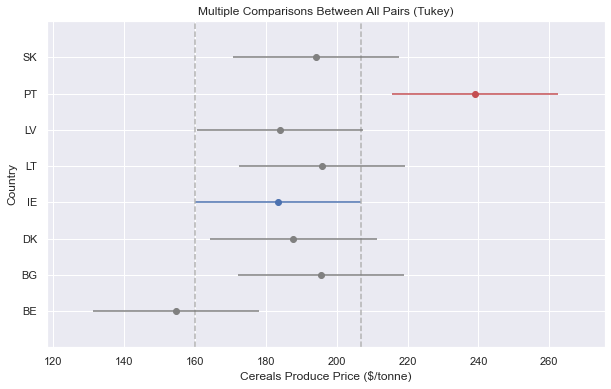

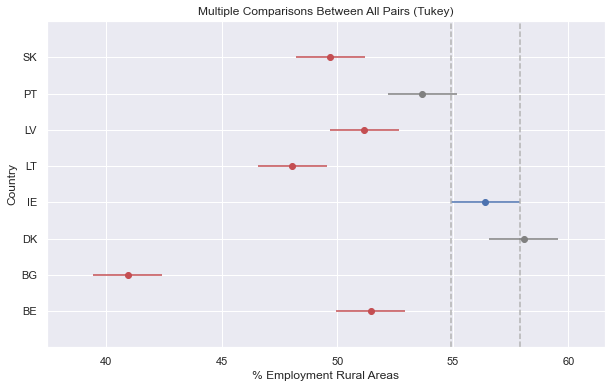

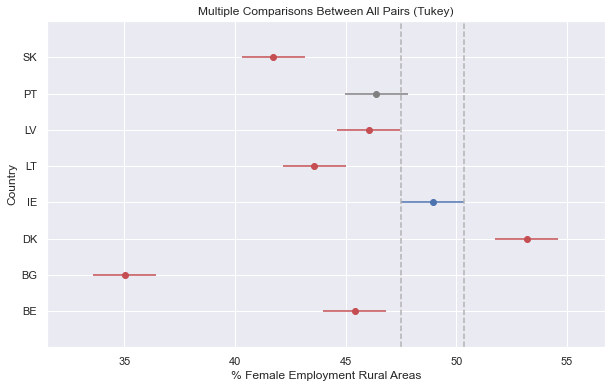

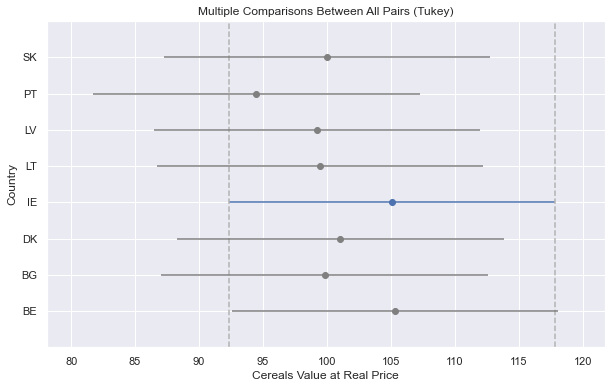

In [23]:
# Run anova report for all valid variables
results_anova = None
for variable in levene_df.query("equal_var == True").variable.unique():
    if(results_anova == None): 
        pvalue, df = agriculture.anova_result(dataset,variable,f"{variable}~country",False, False)
        if(pvalue > 0.05):
            df["variable"] = variable
            results_anova = df.query("group1 == 'IE' or group2 == 'IE' and reject == False")
    else:
        pvalue, df = agriculture.anova_result(dataset,variable,f"{variable}~country",False, False)
        if(pvalue > 0.05):
            df["variable"] = variable
            results_anova.insert(df.query("group1 == 'IE' or group2 == 'IE' and reject == False"),allow_duplicates=True)

In [24]:
results_anova["country_name"] = results_anova.apply(lambda r: country_codes_dic.get(r.group2) if r.group1 == 'IE' else country_codes_dic.get(r.group1), axis=1)
results_anova

C:\Users\rmsry\AppData\Local\Temp\ipykernel_16760\640926075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_anova["country_name"] = results_anova.apply(lambda r: country_codes_dic.get(r.group2) if r.group1 == 'IE' else country_codes_dic.get(r.group1), axis=1)


,group1,group2,meandiff,p-adj,lower,upper,reject,variable,country_name
3,BE,IE,-0.2441,1.0,-25.7708,25.2825,False,prod_cereals_real_price,(BE) Belgium
9,BG,IE,5.2688,0.9983,-20.2578,30.7955,False,prod_cereals_real_price,(BG) Bulgaria
14,DK,IE,4.0294,0.9997,-21.4972,29.556,False,prod_cereals_real_price,(DK) Denmark
19,IE,LT,-5.6288,0.9974,-31.1555,19.8978,False,prod_cereals_real_price,(LT) Lithuania
20,IE,LV,-5.8476,0.9967,-31.3743,19.679,False,prod_cereals_real_price,(LV) Latvia
21,IE,PT,-10.6071,0.9045,-36.1337,14.9196,False,prod_cereals_real_price,(PT) Portugal
22,IE,SK,-5.0918,0.9986,-30.6184,20.4349,False,prod_cereals_real_price,(SK) Slovakia


> Cereals production price and countries Belgium, Denmark, Lithuanian, Latvia, Portugal and Slovakia have same means as Ireland

# Non parametrical test for those variables that do not meet Anova assumptions

In [26]:
# From the variables analised in the anova that do not meet requirements
anova_vars = set(levene_df.query("equal_var == True").variable.unique())
all_columns = set(columns_dic.keys())
all_columns
kruskal_vars = all_columns - anova_vars


print("Variables for selection")
print("=======================")
_ = [print(f"\t{x}") for x in kruskal_vars]

print("Countries for study")
print("=======================")
_ = [print(f"\t{country_codes_dic.get(x)}") for x in levene_df.query("equal_var == True").country.unique()]

countries = list(levene_df.query("equal_var == True").country.unique())
countries.append('IE')
dataset = agriculture_df.query("country in @countries")

results_nonp = [["variable","kruskal_test_result"]]
# KRUSKAL TEST
for variable in kruskal_vars:    
    k = agriculture.kruskal_report(dataset,variable)
    results_nonp.append([variable,k])

Variables for selection
	crop_land_use_1000ha
	total_uaa_ha
	total_subsides_on_field_crops
	gross_value_added
	avg_export_idx
	crop_production_idx
	avg_import_idx
	male_employment_ratio_rural_areas_pct
	male_mean_weekly_working_hours
	wages_and_salaries
	rented_land_ha
	crop_mean_residues_kg
	female_mean_weekly_working_hours
	pct_rented_land_of_uaa
	agri_energy_use_tj
	mean_weekly_working_hours
	rent_paid
	compensation_of_employees
Countries for study
	None
	(BE) Belgium
	(PT) Portugal
	(LV) Latvia
	(DK) Denmark
	(LT) Lithuania
	(BG) Bulgaria
	(SK) Slovakia


[BEGIN]
crop_land_use_1000ha
MultiComparison.kruskal
0 1 105.0 13.621897987977269 7.708176943673586 True
1.2762771641858583e-14


[BEGIN]
total_uaa_ha
MultiComparison.kruskal
0 1 77.8235294117647 13.621897987977269 5.713119381781599 True
1.1092380416806301e-08


[BEGIN]
total_subsides_on_field_crops
MultiComparison.kruskal
0 1 20.382352941176464 13.621897987977269 1.4962931714189898 False
0.13457727380478043


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
gross_value_added
MultiComparison.kruskal
0 1 32.99999999999999 13.621897987977269 2.4225698965831266 False
0.015411160734203205


[BEGIN]
avg_export_idx
MultiComparison.kruskal
0 1 6.794117647058819 13.621897987977269 0.4987643904729964 False
0.6179453765841043


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
crop_production_idx
MultiComparison.kruskal
0 1 11.058823529411761 13.621897987977269 0.8118416052720637 False
0.4168825252346978


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
avg_import_idx
MultiComparison.kruskal
0 1 3.764705882352942 13.621897987977269 0.27637161030538354 False
0.7822626595613973


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
male_employment_ratio_rural_areas_pct
MultiComparison.kruskal
0 1 47.0 13.621897987977269 3.450326822406272 True
0.0005599082689290747


[BEGIN]
male_mean_weekly_working_hours
MultiComparison.kruskal
0 1 55.64705882352942 13.621897987977269 4.085117864826451 True
4.4054448184190805e-05


[BEGIN]
wages_and_salaries
MultiComparison.kruskal
0 1 4.882352941176471 13.621897987977269 0.35841943211479427 False
0.720029451601598


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
rented_land_ha
MultiComparison.kruskal
0 1 39.117647058823536 13.621897987977269 2.871673763329376 True
0.004083042390986826


[BEGIN]
crop_mean_residues_kg
MultiComparison.kruskal
0 1 31.35294117647058 13.621897987977269 2.3016573170745214 False
0.02135450504591285


[BEGIN]
female_mean_weekly_working_hours
MultiComparison.kruskal
0 1 20.411764705882348 13.621897987977269 1.4984523246245007 False
0.13401577047478114


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
pct_rented_land_of_uaa
MultiComparison.kruskal
0 1 25.17647058823529 13.621897987977269 1.8482351439172517 False
0.06456833342893156


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
agri_energy_use_tj
MultiComparison.kruskal
0 1 60.35294117647058 13.621897987977269 4.430582377708179 True
9.397893725946065e-06


[BEGIN]
mean_weekly_working_hours
MultiComparison.kruskal
0 1 49.941176470588246 13.621897987977269 3.6662421429573535 True
0.0002461408700064928


[BEGIN]
rent_paid
MultiComparison.kruskal
0 1 3.823529411764696 13.621897987977269 0.28068991671640436 False
0.7789482432655928


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



[BEGIN]
compensation_of_employees
MultiComparison.kruskal
0 1 14.411764705882348 13.621897987977269 1.0579850707002958 False
0.2900622487821889


<span style='color:green'>H0 ACCEPTED</span>

there is no differences in means of the variable within the countries



## Summary NON parametrical test

In [28]:
print("Non parametrical test comparison indicates similar values with Ireland and selected  \n" +\
      f"Members states {similar_countries} on the following variables")
results_nonp_pd = pd.DataFrame.from_records(np.array(results_nonp)[1:,:], columns=results_nonp[0]);
results_nonp_pd["kruskal_test_result"] = results_nonp_pd.kruskal_test_result.astype("float")
results_nonp_pd.query("kruskal_test_result > 0.05")

Non parametrical test comparison indicates similar values with Ireland and selected  
Members states ['BE', 'PT', 'LV', 'IE', 'DK', 'LT', 'BG', 'SK'] on the following variables


,variable,kruskal_test_result
2,total_subsides_on_field_crops,0.134577
4,avg_export_idx,0.617945
5,crop_production_idx,0.416883
6,avg_import_idx,0.782263
9,wages_and_salaries,0.720029
12,female_mean_weekly_working_hours,0.134016
13,pct_rented_land_of_uaa,0.064568
16,rent_paid,0.778948
17,compensation_of_employees,0.290062


# Employment by gender analysis


In [29]:
dataset[['female_employment_ratio_rural_areas_pct','male_employment_ratio_rural_areas_pct']].corr(method='pearson')

,female_employment_ratio_rural_areas_pct,male_employment_ratio_rural_areas_pct
female_employment_ratio_rural_areas_pct,1.000000,0.812412
male_employment_ratio_rural_areas_pct,0.812412,1.000000


In [30]:
# Check means of the 2 groups male and female.
dataset[['female_employment_ratio_rural_areas_pct','male_employment_ratio_rural_areas_pct']].describe()

,female_employment_ratio_rural_areas_pct,male_employment_ratio_rural_areas_pct
count,136.000000,136.000000
mean,45.039649,57.761099
std,5.640137,6.192587
min,31.300000,42.070000
25%,41.372500,55.090000
50%,45.740000,58.435000
75%,49.240000,60.997500
max,57.210000,73.320000


In [31]:
stat, pvalue = stats.levene(dataset.female_employment_ratio_rural_areas_pct, dataset.male_employment_ratio_rural_areas_pct)
print(f"H0: There is homegeneity of variance in male and female employment ratio with levene test pvalue {pvalue}")

H0: There is homegeneity of variance in male and female employment ratio with levene test pvalue 0.7760850868820971


> BoxPlot employment ratio by gender 

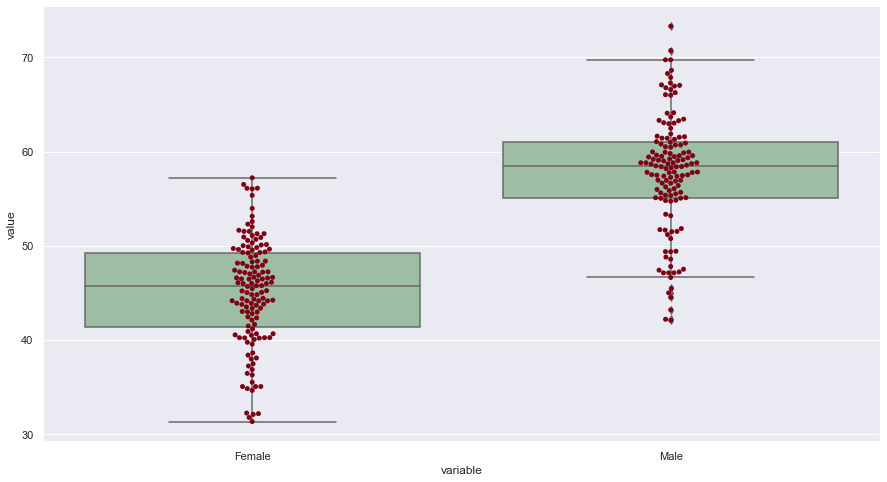

In [32]:
df_gender = dataset[['female_employment_ratio_rural_areas_pct','male_employment_ratio_rural_areas_pct']]
df_gender.columns = ["Female","Male"]
df_melt = df_gender.melt()

# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments

ax = sns.boxplot(x='variable', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="variable", y="value", data=df_melt, color='#7d0013')
plt.show()



[BEGIN]
Female
                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     77.83
Date:                Sat, 21 May 2022   Prob (F-statistic):           2.96e-45
Time:                        19:34:25   Log-Likelihood:                -319.72
No. Observations:                 136   AIC:                             657.4
Df Residuals:                     127   BIC:                             683.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        20.1912     

<span style='color:red'>H0 REJECT, means are not the same</span>

[END REPORT]


2.4488957325328893e-42


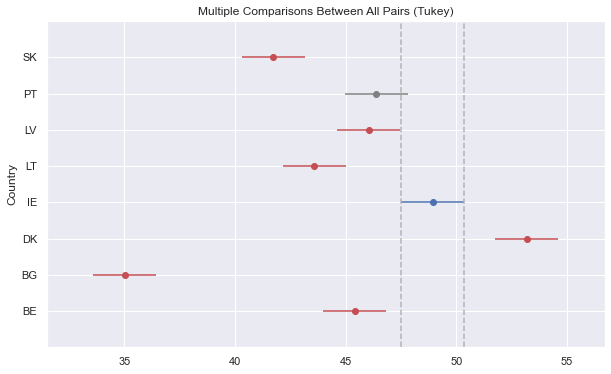

In [33]:
df_gender = dataset[['country','female_employment_ratio_rural_areas_pct','male_employment_ratio_rural_areas_pct']]
df_gender.columns = ['country',"Female","Male"]
pvalue, df_gender_anova_group_result = agriculture.anova_result(df_gender,"Female",f"Male~Female+country", True)
print(pvalue)

The employement ratio for Female population in rural areas is not the same as male on selected countries. Within groups of different countries

In [34]:
df_gender_anova_group_result.query("reject == False and (group1 == 'IE' or group2 == 'IE')")

,group1,group2,meandiff,p-adj,lower,upper,reject
21,IE,PT,-2.5524,0.1133,-5.3971,0.2924,False


> Portugal and Ireland have similar employment for male and femal groups